"""
Idea is to take feature maps from all backbone heads of YOLOv8 and try to locate what features
are corresponding to specific detection regions. Ofc we need to be sure that we are taking output of
hidden layers where spatial structure of output and input image are still align, i.e. leftmost element 
of feature map still corresponds to leftmost region of original image.
Another workaround would be to make a script that runs two (or more) times:
one on full image and another one on image where only detected human is not blanked (or maybe a bit widened bbox)
and then try to see what activations change their output a lot and what are not: this is for the case if 
spatial alignment of features and input image is broken
"""

In [1]:
from collections import OrderedDict
import onnx
import onnxruntime as ort
import numpy as np
from pathlib import Path
from typing import Union, Sequence, List, Dict, Tuple, Optional
import torch
from _yolov8_onnx_preprocessing import core_like_preprocessing
from _yolov8_onnx_postprocessing import non_max_suppression, model_inference_to_annotations
from utils import Annotation, TextStyles, stylish_text, Bbox, file_to_annotation
from image_manipulation_utils import black_out_image_except_bboxes
from PIL import Image
import math
from torchvision.ops import roi_align
import fiftyone as fo
import fiftyone.brain as fob
from umap import UMAP
import io
from tqdm import tqdm
import shutil
import hdbscan
from collections import defaultdict
import matplotlib.pyplot as plt

ImportError: cannot import name 'core_like_preprocessing' from '_yolov8_onnx_preprocessing' (/home/smarkov1001/NVI/scripts/humans/_yolov8_onnx_preprocessing.py)

In [ ]:

class YoloEmbeddingVisualizer:
    # Note: this is given as some class attribute but in fact cannot be easily changed here yet! 
    # some preprocessing and postprocessing methods do depend on value 384 (i.e. on FullHD res of initial image) and should be rewritten
    YOLO_INPUT_SIZE: Tuple[int, int]=(640, 384)  
    # scanning folders will collect only these extensions
    ALLOWED_IMAGE_SUFFIXES = ".jpeg", ".jpg", ".png"  
    # all conv layers outputs will be resized (ROI Align) to this res to provide same output feature vector length
    # 4, 7 (h,w) close to FullHD ratio for image of width 7
    EMBEDDING_TENSORS_HW_RESOLUTION_BEFORE_FLATTENING = (4, 7)   

    def __init__(
        self,
        # onnx_model_path: Union[str, Path],
        # netron_layer_names: Sequence[str],
        output_alias_names: Optional[Dict[int, str]]=None,
        # providers: List[str]=['CUDAExecutionProvider']
    ) -> None:
        # self.onnx_model_path = onnx_model_path
        # self.netron_layer_names = netron_layer_names
        # self.providers = providers
        
        # self.model = onnx.load(onnx_model_path)
        # self.session = ort.InferenceSession(self.model.SerializeToString(), providers=self.providers) # use this session to modify model
        # self._extend_model_outputs_by_outputs_from_layers_of_interest() # add outputs from layers of interest, remove original output
        # self.session = ort.InferenceSession(self.model.SerializeToString(), providers=self.providers) # reinitialize modified model
    
        self.output_alias_names = output_alias_names

    # def get_image_embeddings(
    #         self, 
    #         image_path: Union[str, Path],
    #         load_annotations_from_file: Optional[Union[str, Path]]=None, # optional. Get them from predictions otherwise
    #         conf_thres: float=0.25,
    #         iou_thres: float=0.7
    #     ) -> Dict[str, np.ndarray]:
    #     NETWORK_HEAD_OUTPUT_NAME = 'output0'
    #     preprocessed_image = core_like_preprocessing(Path(image_path))
    #     image_inference_outputs: Dict[str, np.ndarray] = self._get_outputs_from_layers_of_interest(preprocessed_image)

    #     ## ==== get predicted bboxes, apply NMS and normalization if they came from predictions 
    #     if (load_annotations_from_file is not None) and load_annotations_from_file.is_file():
    #         normalized_annotations = file_to_annotation(load_annotations_from_file)
    #     else:
    #         predictions_before_nms: np.ndarray = image_inference_outputs[NETWORK_HEAD_OUTPUT_NAME]
    #         normalized_annotations = self._get_annotation_list_from_predictions(predictions_before_nms, conf_thres, iou_thres)

    #     ## ==== get feature vectors from each hidden layer of interest that correspond to found bboxes
    #     annotation_embeddings_pairs = {}
    #     for annotation in normalized_annotations:
    #         feature_vectors = []
    #         bbox = annotation.bbox
    #         for layer_name, output_array in image_inference_outputs.items():
    #             if layer_name == NETWORK_HEAD_OUTPUT_NAME: # no interest in output from yolo head
    #                 continue
    #             _ , c, h, w = output_array.shape    
    #             feature_map_box = list(map(math.ceil, [w*bbox.x_min, h*bbox.y_min, w*bbox.x_max, h*bbox.y_max]))
    #             x1, y1, x2, y2 = feature_map_box
    #             # adding 1 to include the last cell when slicing x1 : x2
    #             if x2 <= w:
    #                 x2 += 1
    #             if y2 <= h:
    #                 y2 += 1
    #             feature_vector = output_array[:, :, y1: y2, x1: x2]
    #             feature_vectors.append(feature_vector)
            
    #         ## ==== now we have collected all feature vectors. Let's use ROI align to make their resolution same
    #         feature_tensors = [torch.tensor(fv) for fv in feature_vectors]

    #         # TODO: for each feature tensor use PCA (principal component analysis) with beforehead setted up number of principal components
    #         # TODO: (i.e. number of channels we want to keep). Reduce channel dimensionality for each tensor

    #         rois = torch.tensor([
    #             [0, 0, 0, fv.shape[3] - 1, fv.shape[2] - 1] # batch index, x1, y1, x2, y2
    #             for fv in feature_tensors
    #         ], dtype=torch.float32)

    #         output_size = YoloBboxEmbeddings.EMBEDDING_TENSORS_HW_RESOLUTION_BEFORE_FLATTENING # let's use 4 x 7 output resolution as it is close to FullHD ratio of image of width 7 

    #         aligned_tensors: List[torch.Tensor] = [
    #             roi_align(fv, rois[fv_idx].unsqueeze(0), output_size, aligned=True)
    #             for fv_idx, fv in enumerate(feature_tensors)
    #         ]

    #         flattened_tensors = [t.flatten(start_dim=1) for t in aligned_tensors]
    #         embedding_vector = torch.cat(flattened_tensors, dim=1).numpy()

    #         annotation_embeddings_pairs[annotation] = embedding_vector

    #     return annotation_embeddings_pairs

    # def _extend_model_outputs_by_outputs_from_layers_of_interest(self) -> None:
    #     """
    #     looping through model outputs will gives us only main model output defined by architecture
    #     If we want to get outputs from some hidden layers where it was not assumed initially
    #     we need to modify onnx file so that hidden layers of our interest would also produce outputs
    #     """
    #     # existing outputs
    #     org_outputs = [x.name for x in self.session.get_outputs()]

    #     node_names_to_nodes = self._map_netron_layer_names_to_nodes()

    #     # adding outputs to hidden layers
    #     for node in self.model.graph.node:
    #         if node not in node_names_to_nodes.values(): # exclude any node that does not correspond to a node with name in netron_layer_names
    #             continue
    #         for output in node.output:
    #             if output not in org_outputs:
    #                 self.model.graph.output.extend([onnx.ValueInfoProto(name=output)])    
        

    # def _map_netron_layer_names_to_nodes(self) -> Dict[str, onnx.onnx_ml_pb2.NodeProto]:
    #     """
    #     @returns: mapping of node_name to node object 
    #     @raises: ValueError if there are no nodes with names provided in netron_layer_names in the network
    #     """
    #     ret = {}
    #     for node in self.model.graph.node:
    #         for node_name in self.netron_layer_names:
    #             if node.name == node_name:
    #                 ret[node_name] = node
    #     not_found_names = set(self.netron_layer_names).difference(set(ret.keys()))
    #     if len(not_found_names):
    #         raise ValueError(f"NN nodes were not found for some provided netron_layer_names: {not_found_names}.")
    #     return ret    
    

    # def _get_outputs_from_layers_of_interest(self, input_array: np.ndarray) -> Dict[str, np.ndarray]:
    #     outputs = [x.name for x in self.session.get_outputs()]
    #     ort_outs = self.session.run(outputs, {self.session.get_inputs()[0].name: input_array})
    #     ort_outs = OrderedDict(zip(outputs, ort_outs))       
    #     return ort_outs
    

    # def _get_annotation_list_from_predictions(
    #         self, 
    #         predictions_before_nms: np.ndarray,
    #         conf_thres: float=0.25,
    #         iou_thres: float=0.7
    #     ) -> List[Annotation]:
    #     predictions_before_nms_tensor: torch.Tensor = torch.from_numpy(predictions_before_nms)
    #     xyxy_predictions_list: list = non_max_suppression(predictions_before_nms_tensor, conf_thres=conf_thres, iou_thres=iou_thres)
    #     xyxy_predictions: torch.Tensor = xyxy_predictions_list[0]
    #     xyxy_predictions_array: np.ndarray = xyxy_predictions.numpy()
    #     annotations_in_abs_coordinates: List[Annotation] = model_inference_to_annotations(xyxy_predictions_array) # abs coords on input image
    #     normalized_annotations: List[Annotation] = []
    #     for annotation in annotations_in_abs_coordinates:
    #         bbox = annotation.bbox.normalize(YoloBboxEmbeddings.YOLO_INPUT_SIZE)
    #         normalized_annotations.append(
    #             Annotation(
    #                 annotation.class_index,
    #                 bbox,
    #                 annotation.confidence
    #             )
    #         )
    #     return normalized_annotations


    # def crop_bboxes_calculate_and_store_embeddings_of_dir(
    #         self, 
    #         dir_path: Union[str, Path], 
    #         temporal_folder: Union[str, Path], 
    #         from_annotations_in_dir: bool=False,  # what is the source of annotations? exising markup or inference?
    #         conf_thres: float=0.25,
    #         iou_thres: float=0.7
    #     ):
    #     print(stylish_text("Note: only 16:9 images will be processed to obtain bbox crops and embeddings.", TextStyles.WARNING))
    #     ## inspecting if there are any files in temporal folder and whether to delete them or not
    #     temporal_folder = Path(temporal_folder)
    #     if not temporal_folder.is_dir():
    #         temporal_folder.mkdir(exist_ok=True, parents=True)
    #     else:
    #         if len(list(temporal_folder.iterdir())):
    #             user_input: str = ""
    #             while user_input not in ('y', 'n'):
    #                 print(stylish_text(f"tmp folder to store cropped images is not empty: {temporal_folder}", TextStyles.FAIL))
    #                 user_input = input("remove files? (y/n): ").lower().strip()
    #             if user_input == 'y':
    #                 shutil.rmtree(temporal_folder)
    #                 temporal_folder.mkdir(exist_ok=True, parents=True)

    #     ## collecting images for inference and embedding calculations
    #     images: List[Path] = self.__collect_images_from_dir(dir_path, full_hd_ratio=True) # TODO: fix preprocessing in case image is not 16:9
    #     return self.crop_bboxes_calculate_and_store_embeddings_of_image_list(images, temporal_folder, from_annotations_in_dir, conf_thres, iou_thres)


    def __collect_images_from_dir(self, folder: Union[str, Path], full_hd_ratio: bool=False) -> List[Path]:
        images = [
            image for image in Path(folder).glob("*.*") 
            if (image.is_file() and (image.suffix in YoloEmbeddingVisualizer.ALLOWED_IMAGE_SUFFIXES))
        ]
        if full_hd_ratio == True:
            condition = lambda w, h: ((w / 16) == (h / 9)) and (w % 16 == 0) 
            images = [image for image in images if condition(*Image.open(image).size)]    
        return images        
    

    # def crop_bboxes_calculate_and_store_embeddings_of_image_list(
    #         self, 
    #         images: List[Path], 
    #         temporal_folder: Path,
    #         from_annotations_in_dir: bool=False,  # this allows us to get features for bboxes defined in the .txt annotation files in dir instead of by predictions
    #         conf_thres: float=0.25,
    #         iou_thres: float=0.7
    #     ):
    #     print(stylish_text(f"Running inference with model: {self.onnx_model_path}", style=TextStyles.OKBLUE))
    #     print(stylish_text("Getting predictions, image_cuts and calculating embeddings", style=TextStyles.OKBLUE))
    #     for image_path in tqdm(images):
    #         annotation_dict = (  # get embeddings from predictions if load_annotations_from_file is False else searh for filename as image_path.name with .txt
    #             self.get_image_embeddings(image_path, None, conf_thres, iou_thres) 
    #             if not from_annotations_in_dir 
    #             else self.get_image_embeddings(image_path, load_annotations_from_file=image_path.with_suffix(".txt"))
    #         )
    #         for annotation, embedding in annotation_dict.items():
    #             bbox = annotation.bbox
    #             cropped_image_path = self._save_cropped_image(image_path, bbox, temporal_folder)
    #             np.save(cropped_image_path.with_suffix(".npy"), embedding)
    #             Path(cropped_image_path.with_suffix(".txt")).write_text(annotation.to_yolo_annotation_line()) 
        
        
    # def _save_cropped_image(self, image_path: Union[str, Path], bbox_obj: Bbox, output_dir: Path) -> Path:
    #     with Image.open(image_path) as img:
    #         # Convert relative bbox coordinates to absolute
    #         abs_bbox = bbox_obj.to_absolute((img.width, img.height)).rectangle()
    #         cropped_img = img.crop(abs_bbox)
            
    #         # Create a base output path without the counter
    #         base_output_path = output_dir / (Path(image_path).stem + "_cropped")
    #         output_path = Path(str(base_output_path) + ".jpg")
    #         counter = 1
    #         # Modify the output path with the counter if the file already exists
    #         while output_path.is_file():
    #             output_path = base_output_path.with_name(base_output_path.name + f"_{counter}.jpg")
    #             counter += 1
    #         cropped_img.save(output_path)
    #         return output_path
        
    
    def plot_stored_crop_embedding_pairs(
            self, 
            folder_with_crops_and_embeddings: Union[str, Path],
            class_of_interest: Optional[Union[int, str]] = None, # all classes if None
            ground_truth_markup_dir: Optional[Union[str, Path]]=None,
            tp_threshold: float=0.4, # if ground truth is given when prediction is tp and when is fp?
            plot_height: int=800
        ):

        annotations, embedding_files, image_paths = self._load_stored_embeddings(folder_with_crops_and_embeddings, class_of_interest)

        # let's find corresponding ground truth markup files
        if ground_truth_markup_dir is not None:
            gt_files = self._load_ground_truth_markup_for_image_crop_file_paths(image_paths, ground_truth_markup_dir)

        dataset_name = 'Yolo_Bbox_Embeddings'
        if dataset_name in fo.list_datasets():
            fo.delete_dataset(dataset_name)  # Or choose a different name

        dataset = fo.Dataset(dataset_name)

        samples = [fo.Sample(filepath=image_path) for image_path in image_paths]
        # assign class index to each sample as well as detection status (TP, FP) if ground_truth_markup_dir is not None
        for sample_idx, sample in enumerate(samples):
            corresponding_annotation = annotations[sample_idx]
            sample.tags.append(
                f"class_{corresponding_annotation.class_index}"
                if self.output_alias_names is None
                else self.output_alias_names[corresponding_annotation.class_index]
            )
            if ground_truth_markup_dir is not None:
                corresponding_gt_file = gt_files[sample_idx]
                detection_status = self._assign_detection_status_to_prediction(corresponding_annotation, corresponding_gt_file, tp_threshold)
                sample.tags.append(detection_status)
        
        embeddings = [np.load(embedding_file) for embedding_file in embedding_files]        

        embeddings_array = np.array(embeddings).squeeze(axis=1)
        
        dataset.add_samples(samples)

        results = fob.compute_visualization(
            dataset,
            brain_key="umap",  # Key to associate with this brain method
            embeddings=embeddings_array,
            method="umap",  # Visualization method
            num_dims=2  # Number of dimensions for the visualization
        )

        ## visualization
        dataset_view = dataset.view()
        session = fo.launch_app(view=dataset_view)
        plot = results.visualize()
        plot.show(height=plot_height)

        # Attach plot to session
        session.plots.attach(plot)


    def _load_stored_embeddings(
            self, 
            folder_with_crops_and_embeddings: Union[str, Path],
            class_of_interest: Optional[Union[int, str]] = None, # all classes if None
        ) -> Tuple[List[Annotation], List[Path], List[Path]]:
        """
        @returns: tuple: annotations List[Annotation], embedding_files List[Path], image_paths List[Path]
        """

        image_paths = sorted(self.__collect_images_from_dir(folder_with_crops_and_embeddings))
        embedding_files = [item.with_suffix(".npy") for item in image_paths]
        annotations = [file_to_annotation(image_path.with_suffix(".txt"))[0] for image_path in image_paths] # 0 as one image one annotation


        # let's filter annotations by class of interested if there is one
        if class_of_interest is not None:
            if type(class_of_interest) == str:
                class_of_interest = {v : k for k, v in self.output_alias_names.items()}[class_of_interest]
            condition = lambda item: item.class_index == class_of_interest
            filtered = [
                (a, e, i) for (a, e, i) in zip(annotations, embedding_files, image_paths)
                if condition(a)
            ]
            annotations, embedding_files, image_paths = map(list, zip(*filtered)) if filtered else ([], [], [])      

        if not all(embedding_file.is_file() for embedding_file in embedding_files):
            print(stylish_text("Embeddings are missing for some images. Seems dir is corrupted. Exiting.", TextStyles.FAIL))
            exit()
        
        return annotations, embedding_files, image_paths  
    

    def _load_ground_truth_markup_for_image_crop_file_paths(
            self, 
            crop_file_paths: List[Path], 
            ground_truth_markup_dir: Union[str, Path]
        ) -> List[Path]:
        gt_files = [
            Path(ground_truth_markup_dir) /  f"{str(image_path.name).split('_cropped')[0]}.txt"
            for image_path in crop_file_paths
        ]  

        if not all(file.is_file() for file in gt_files):
            print(stylish_text("ground truth files not found for some croped images. Fix your directories", TextStyles.FAIL))
            exit()
        
        return gt_files

    def _assign_detection_status_to_prediction(
            self, 
            crop_annotation: Annotation, 
            ground_truth_annotation_file: Union[str, Path],
            tp_treshhold: float=0.4
        ) -> str:
        """
        is this cropped image TP, FP? (I do not assign FN as it is a status of ground truth markup. TN is not well-defined in detection problem) 
        """
        gt_annotations = file_to_annotation(ground_truth_annotation_file)
        for gt in gt_annotations:
            if gt.class_index != crop_annotation.class_index:
                continue
            if Bbox.IoU(gt.bbox, crop_annotation.bbox) >= tp_treshhold:
                return 'tp'
        return 'fp'
    

    def plot_val_embeddings_against_train_embeddings(
            self, 
            stored_source_embeddings_dir: Union[str, Path],
            stored_val_embeddings_dir: Union[str, Path],
            val_ground_truth_markup_dir: Union[str, Path],
            # output_directory: Union[str, Path],
            class_of_interest: Optional[Union[str, int]],
            tp_threshold: float=0.3,
            plot_height: int=800,
            # save_clustering_results: bool=True
        ):

        src_annotations, src_embedding_files, src_image_paths = self._load_stored_embeddings(stored_source_embeddings_dir, class_of_interest)
        val_annotations, val_embedding_files, val_image_paths = self._load_stored_embeddings(stored_val_embeddings_dir, class_of_interest)

        # TODO: make it normal
        N = 60000
        src_annotations = src_annotations[: N]
        src_embedding_files = src_embedding_files[:N]
        src_image_paths = src_image_paths[:N]

        dataset_name = 'train_val_dataset'
        if dataset_name in fo.list_datasets():
            fo.delete_dataset(dataset_name)  # Or choose a different name

        dataset = fo.Dataset(dataset_name)

        image_paths = src_image_paths + val_image_paths

        samples = [fo.Sample(filepath=image_path) for image_path in image_paths]
        annotations = src_annotations + val_annotations

        gt_files = self._load_ground_truth_markup_for_image_crop_file_paths(val_image_paths, val_ground_truth_markup_dir)
        print(stylish_text("collecting stored data: images, embeddings, labels", TextStyles.OKBLUE))
        for sample_idx, sample in enumerate(tqdm(samples)):
            tag = 'src' if (sample_idx < len(src_image_paths)) else 'val'
            sample.tags.append(tag) 
            corresponding_annotation = annotations[sample_idx]
            sample.tags.append(
                f"class_{corresponding_annotation.class_index}"
                if self.output_alias_names is None
                else self.output_alias_names[corresponding_annotation.class_index]
            )

            if tag == 'val':
                assert sample_idx >= len(src_image_paths)
                corresponding_gt_file = gt_files[sample_idx - len(src_image_paths)]
                detection_status = self._assign_detection_status_to_prediction(corresponding_annotation, corresponding_gt_file, tp_threshold)
                sample.tags.append(detection_status)
        
        embeddings = [np.load(embedding_file) for embedding_file in (src_embedding_files + val_embedding_files)]        

        embeddings_array = np.array(embeddings).squeeze(axis=1)
        
        dataset.add_samples(samples)
        print(stylish_text("computing umap representations", TextStyles.OKBLUE))
        results = fob.compute_visualization(
            dataset,
            brain_key="umap",  # Key to associate with this brain method
            embeddings=embeddings_array,
            method="umap",  # Visualization method
            num_dims=2  # Number of dimensions for the visualization
        )

        # Extract the UMAP points
        umap_points = results.points  # This should be an Nx2 NumPy array

        # Assign colors based on tags
        colors = []
        for sample in dataset:
            if 'src' in sample.tags:
                colors.append('blue')  # Blue for 'src'
            elif 'fp' in sample.tags:
                colors.append('black')
            elif 'tp' in sample.tags:
                colors.append('red')
            else:
                colors.append('gray')  # Gray for samples without 'src' or 'val' tags

        # Create a non-interactive plot with matplotlib
        plt.figure(figsize=(18, 11))
        plt.scatter(umap_points[:, 0], umap_points[:, 1], c=colors, alpha=0.5, s=10)
        plt.title('UMAP Visualization with Tag-based Coloring')
        plt.show()

        # print(stylish_text("performing clusterization of data", TextStyles.OKBLUE))
        # cluster_analysis = self._perform_cluster_analysis(dataset)
        
        # if save_clustering_results == True:
        #     self._save_clustered_representation(cluster_analysis, output_directory)

        ## visualization
        dataset_view = dataset.view()
        session = fo.launch_app(view=dataset_view)
        plot = results.visualize()
        plot.show(height=plot_height)

        # Attach plot to session
        session.plots.attach(plot)
    

    # def _perform_cluster_analysis(
    #     self,
    #     fiftyone_dataset: fo.Dataset
    # ) -> Dict[int, Dict[str, List[str]]]:
    #     cluster_labels = self._clusterize_umap_representations(fiftyone_dataset, min_cluster_size=5)
        
    #     cluster_analysis = defaultdict(lambda: {'val_fp': [], 'src': []})

    #     for sample, cluster_label in zip(fiftyone_dataset, cluster_labels):
    #         # Skip noise points labeled as -1
    #         if cluster_label == -1:
    #             continue

    #         # Determine the list to which the sample's filepath should be added
    #         if 'fp' in sample.tags:
    #             cluster_analysis[cluster_label]['val_fp'].append(sample.filepath)
    #         elif 'src' in sample.tags:
    #             cluster_analysis[cluster_label]['src'].append(sample.filepath)

    #     # Remove any cluster_label for which "val_fp" list is empty
    #     keys_to_remove = [key for key, val in cluster_analysis.items() if not val['val_fp']]
    #     for key in keys_to_remove:
    #         del cluster_analysis[key]        

    #     return cluster_analysis

    # def _clusterize_umap_representations(
    #         self, 
    #         fiftyone_dataset: fo.Dataset, 
    #         min_cluster_size: int=5, 
    #         min_samples=None
    #     ) -> np.ndarray:
    #     """
    #     Clusters the given dataset using HDBSCAN.

    #     :param data: The dataset to cluster, expected to be a NumPy array of shape (n_samples, n_features).
    #     :param min_cluster_size: The minimum size of clusters; smaller clusters will be considered noise.
    #     :param min_samples: The number of samples in a neighborhood for a point to be considered a core point.
    #     :return: The cluster labels for each point in the dataset. (np.ndarray of integer values, value=-1 is considered noise)
    #     """        
    #     data = np.array(
    #         [sample['umap'].vector for sample in fiftyone_dataset]
    #     )
    #     clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True)
    #     clusterer.fit(data)
        
    #     return clusterer.labels_  # note that -1 value in this array is considered noise


    # def _save_clustered_representation(self, cluster_analysis: Dict[int, Dict[str, List[str]]], output_directory: Path) -> None:
    #     """
    #     Saves the clustered data into an organized directory structure.

    #     Parameters:
    #     - cluster_analysis: A dictionary where each key is a cluster label and each value is another
    #       dictionary with keys 'val_fp' and 'src', containing lists of filepaths.
    #     - output_directory: A Path object pointing to the root directory where the clustered data
    #       should be saved.

    #     The method organizes the data into subdirectories named after the cluster labels. Within each
    #     cluster's subdirectory, it creates further subdirectories for 'val_fp' and 'src' categories
    #     and copies the respective files into these locations.
    #     """
    #     for cluster_label, paths_dict in cluster_analysis.items():
    #         for category, filepaths in paths_dict.items():
    #             # Create subdirectories for "val_fp" and "src", including the cluster subdirectory
    #             category_subdir = output_directory / str(cluster_label) / category
    #             category_subdir.mkdir(parents=True, exist_ok=True)
                
    #             # Copy each file to its designated subdirectory
    #             for filepath in filepaths:
    #                 src_path = Path(filepath)  # Source file path
    #                 dst_path = category_subdir / src_path.name  # Destination path
                    
    #                 # Use shutil to copy the file to the destination
    #                 shutil.copy(src_path, dst_path)
    



collecting stored data: images, embeddings, labels


100%|██████████| 72022/72022 [00:11<00:00, 6480.04it/s]  


 100% |█████████████| 72022/72022 [7.1s elapsed, 0s remaining, 11.4K samples/s]      
computing umap representations
Generating visualization...
UMAP( verbose=True)
Thu Feb  8 16:41:27 2024 Construct fuzzy simplicial set
Thu Feb  8 16:41:28 2024 Finding Nearest Neighbors
Thu Feb  8 16:41:28 2024 Building RP forest with 18 trees
Thu Feb  8 16:41:33 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Feb  8 16:41:47 2024 Finished Nearest Neighbor Search
Thu Feb  8 16:41:49 2024 Construct embedding


/home/smarkov1001/python_venvs/onnxruntime_env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Feb  8 16:42:11 2024 Finished embedding


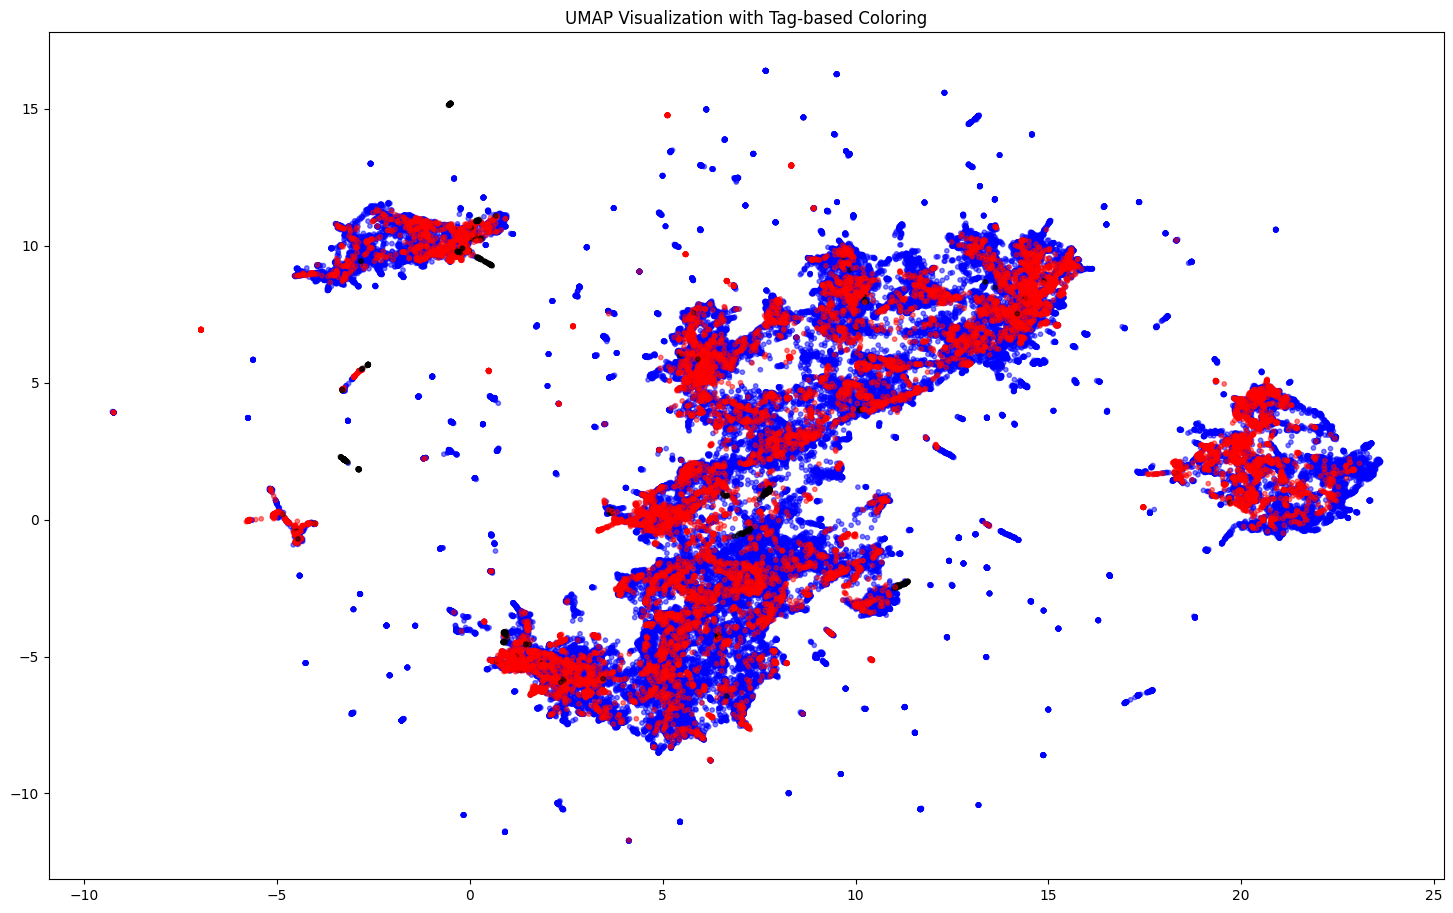

FigureWidget({
    'data': [{'customdata': array(['65c4d9fffff36de72d0a9090', '65c4d9fffff36de72d0a9091',
                                   '65c4d9fffff36de72d0a9092', ..., '65c4da06fff36de72d0ba9e3',
                                   '65c4da06fff36de72d0ba9e4', '65c4da06fff36de72d0ba9e5'], dtype=object),
              'hovertemplate': 'x, y = %{x:.3f}, %{y:.3f}<br>ID: %{customdata}<extra></extra>',
              'mode': 'markers',
              'type': 'scattergl',
              'uid': '7f94b2cb-98ce-4bd5-b491-fc2fe26a9602',
              'x': array([14.29276  , 19.124197 , 20.092247 , ...,  6.6408715,  6.2436986,
                           6.4927053], dtype=float32),
              'y': array([ 9.070511  ,  2.6697054 ,  4.197157  , ..., -1.9757093 , -0.1370165 ,
                          -0.33734927], dtype=float32)}],
    'layout': {'height': 800, 'margin': {'b': 0, 'l': 0, 'r': 0, 't': 30}, 'template': '...'}
})

In [ ]:
output_alias_names = {
    0: 'head',
    1: 'human'
}
yev = YoloEmbeddingVisualizer(output_alias_names)

# yev.plot_stored_crop_embedding_pairs(
#     folder_with_crops_and_embeddings="/media/smarkov1001/storage_ssd/embedding_analysis_data/runs/concat_1/run64_on_val",
#     class_of_interest=1,
#     ground_truth_markup_dir="/home/smarkov1001/sm_3.46/outputs/human_head_detection_yolov8_dataset/val",
#     tp_threshold=0.25,
#     plot_height=800
# )

# yev.plot_stored_crop_embedding_pairs(
#     folder_with_crops_and_embeddings="/media/smarkov1001/storage_ssd/embedding_analysis_data/runs/mul/run62_on_val",
#     class_of_interest=1,
#     ground_truth_markup_dir="/home/smarkov1001/sm_3.46/outputs/human_head_detection_yolov8_dataset/val",
#     tp_threshold=0.25,
#     plot_height=800
# )

yev.plot_val_embeddings_against_train_embeddings(
    stored_source_embeddings_dir="/media/smarkov1001/storage_ssd/embedding_analysis_data/runs/4_layers/run62_REDUCED512/run62_on_train",
    stored_val_embeddings_dir="/media/smarkov1001/storage_ssd/embedding_analysis_data/runs/4_layers/run62_REDUCED512/run62_on_val",
    val_ground_truth_markup_dir="/home/smarkov1001/sm_3.46/outputs/human_head_detection_yolov8_dataset/val",
    class_of_interest=1,
    tp_threshold=0.05,
    plot_height=800
)













# ybe.crop_bboxes_calculate_and_store_embeddings_of_dir(
#     "/home/smarkov1001/sm_3.46/outputs/human_head_detection_yolov8_dataset/train",
#     temporal_folder="/home/smarkov1001/NVI/scripts/humans/runs/run62_on_train"
# )
# ybe.crop_bboxes_calculate_and_store_embeddings_of_dir(
#     "/home/smarkov1001/sm_3.46/outputs/human_head_detection_yolov8_dataset/val",
#     temporal_folder="/home/smarkov1001/NVI/scripts/humans/runs/run62_on_val"
# )

# ybe.produce_fp_eliminating_examples(
#     stored_source_embeddings_dir="/media/smarkov1001/storage_ssd/embedding_analysis_data/runs/run62_on_train",
#     stored_val_embeddings_dir="/media/smarkov1001/storage_ssd/embedding_analysis_data/runs/run62_on_val",
#     val_ground_truth_markup_dir="/home/smarkov1001/sm_3.46/outputs/human_head_detection_yolov8_dataset/val",
#     output_directory="/media/smarkov1001/storage_ssd/embedding_analysis_data/clustering_results/src0_30/",
#     class_of_interest=1,
#     tp_threshold=0.3,
#     plot_height=800,
#     save_clustering_results=True
# )

# ybe.plot_stored_crop_embedding_pairs(
#     folder_with_crops_and_embeddings="/home/smarkov1001/NVI/scripts/humans/runs/run62_on_validation",
#     class_of_interest='human',
#     ground_truth_markup_dir="/home/smarkov1001/sm_3.46/outputs/human_head_detection_yolov8_dataset/val",
#     tp_threshold=0.3
# )
